In [37]:
# Ce projet utilise les bibliothèques suivantes :
#
# - numpy==1.24.1
# - matplotlib==3.7.1
# - pandas==2.1.4
# - torch==2.0.1+cu117
# - scikit-learn==1.2.2
# - optuna==3.6.0
# - shap==0.43.0
# - captum==0.7.0
# - scipy==1.10.1

numpy==1.24.1
matplotlib==3.7.1
pandas==2.1.4
torch==2.0.1+cu117
scikit-learn==1.2.2
optuna==3.6.0
shap==0.43.0
captum==0.7.0
scipy==1.10.1
random==Builtin, no specific version


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import TimeSeriesSplit, KFold
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import shap
from captum.attr import GradientShap, IntegratedGradients
import random

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Function to set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed for all libraries
seed = 42
set_seed(seed)

In [5]:
####### CREATION D'UNE SERIE CIBLE SYNTHETIQUE A PARTIR DE SINUSOIDE ET DE BRUIT #######

####### UTILISATION DES SINUSOIDES ET DU BRUIT COMME COVARIATES #######

n_days = 365  # 1 an avec des pas de temps journaliers
time = np.arange(n_days)
amplitude_1 = 10  # Amplitude de la première sinusoïde
frequency_1 = 8 / 365  # Fréquence annuelle (1 cycle par an)
amplitude_2 = 5  # Amplitude de la deuxième sinusoïde
frequency_2 = 24 / 365  # Fréquence semestrielle (2 cycles par an)
noise_std = 2  # Écart-type du bruit

# Génération de la série temporelle
sinusoid_1 = amplitude_1 * np.sin(2 * np.pi * frequency_1 * time)
sinusoid_2 = amplitude_2 * np.sin(2 * np.pi * frequency_2 * time)
noise = np.random.normal(0, noise_std, n_days)

# Série temporelle cible
target_series = sinusoid_1 + sinusoid_2 + noise

# Création d'un DataFrame
dates = pd.date_range(start="2024-01-01", periods=n_days, freq="D")

dataset = pd.DataFrame({
    "Target": target_series,
    "sinusoid_1": sinusoid_1,
    "sinusoid_2": sinusoid_2,
    "noise": noise
}, index=dates)


In [6]:
dataset.head()

Target  sinusoid_1  sinusoid_2     noise
2024-01-01   0.993428    0.000000    0.000000  0.993428
2024-01-02   3.103699    1.372788    2.007440 -0.276529
2024-01-03   7.692044    2.719582    3.677085  1.295377
2024-01-04  11.788922    4.014880    4.727982  3.046060
2024-01-05   9.749144    5.234156    4.983295 -0.468307

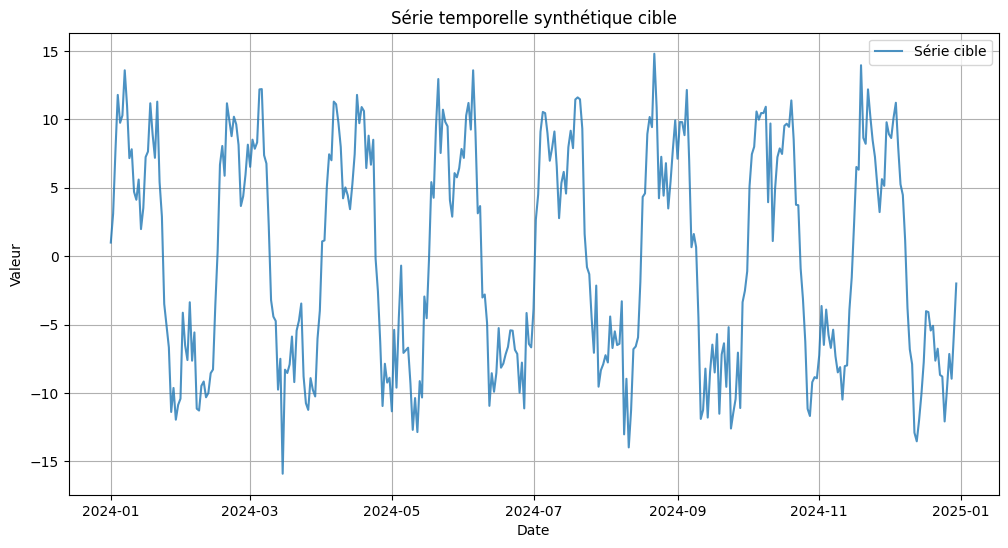

In [7]:
# Affichage de la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset["Target"], label="Série cible", alpha=0.8)
plt.title("Série temporelle synthétique cible")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid()
plt.show()

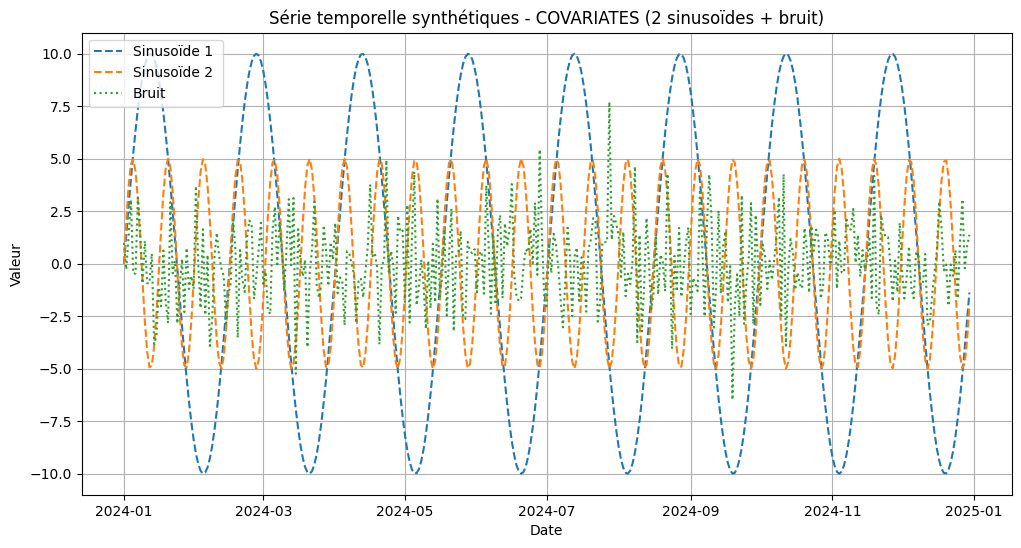

In [8]:
# Covariates
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset["sinusoid_1"], label="Sinusoïde 1", linestyle="--")
plt.plot(dataset.index, dataset["sinusoid_2"], label="Sinusoïde 2 ", linestyle="--")
plt.plot(dataset.index, dataset["noise"], label="Bruit", linestyle=":")
plt.title("Série temporelle synthétiques - COVARIATES (2 sinusoïdes + bruit)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid()
plt.show()

In [9]:
dataset.head()

Target  sinusoid_1  sinusoid_2     noise
2024-01-01   0.993428    0.000000    0.000000  0.993428
2024-01-02   3.103699    1.372788    2.007440 -0.276529
2024-01-03   7.692044    2.719582    3.677085  1.295377
2024-01-04  11.788922    4.014880    4.727982  3.046060
2024-01-05   9.749144    5.234156    4.983295 -0.468307

In [10]:
feature_cols = dataset.drop(['Target'], axis=1).columns.tolist()
target_col = 'Target'

# Obtenir les tableaux de features et la cible
X = dataset[feature_cols].values  # Toutes les features sauf 'Target'
Y = dataset[target_col].values.reshape(-1, 1)

# Définir la date pour la séparation
date_sep = "2024-11-01"
sep_index = dataset.index.get_loc(date_sep)

# Séparer les données en ensembles d'entraînement et de test
X_train = X[:sep_index + 1]
X_test = X[sep_index + 1:]

Y_train = Y[:sep_index + 1]
Y_test = Y[sep_index + 1:]

# Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

# Ensembles d'entraînement
training_set = X_train_scaled
target_set = Y_train_scaled



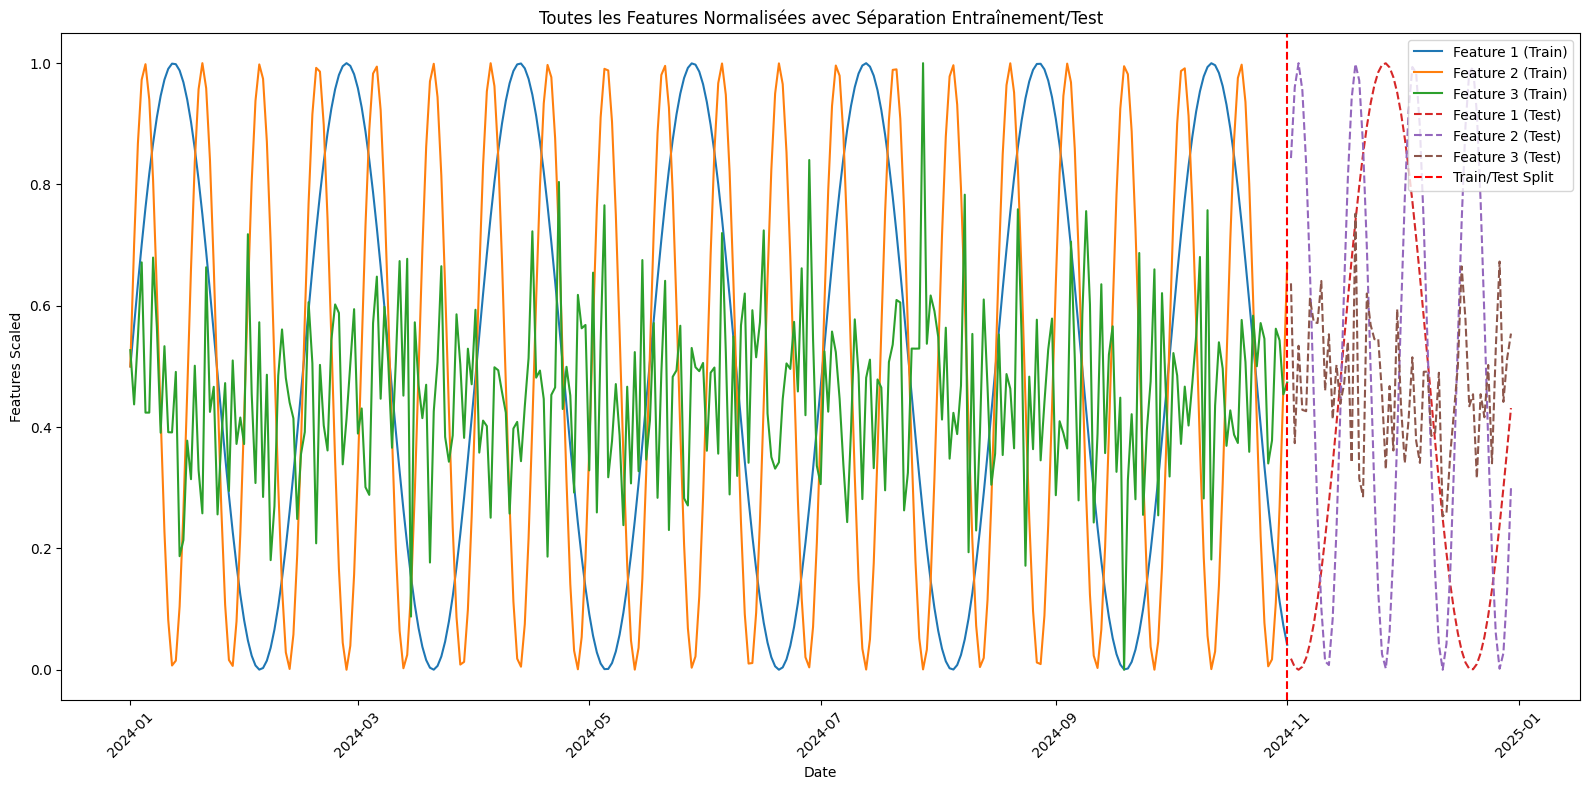

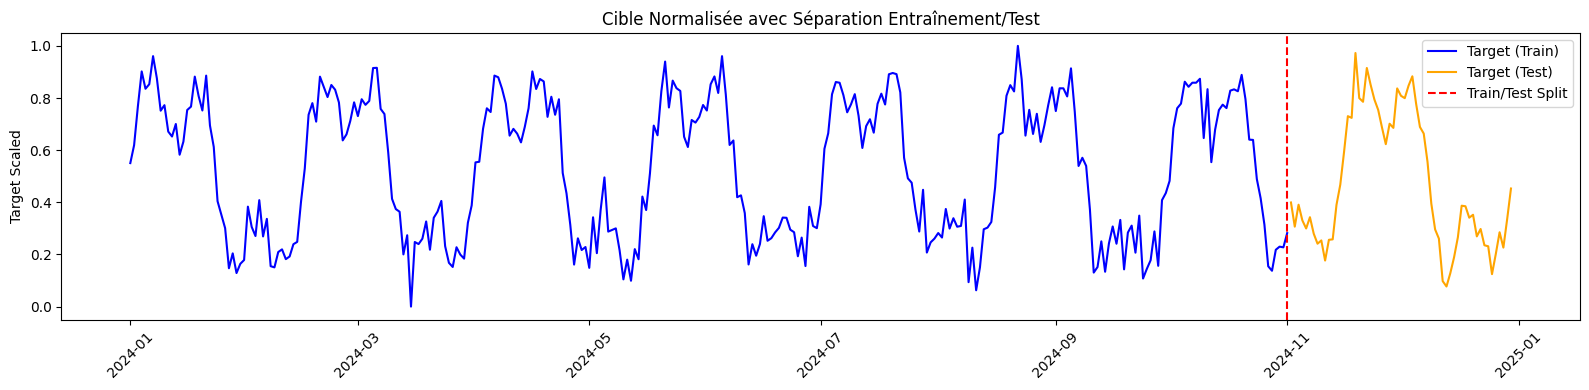

In [11]:
dates = dataset.index

# Séparer les dates en ensembles d'entraînement et de test
dates_train = dates[:sep_index + 1]
dates_test = dates[sep_index + 1:]

# Nombre total de features
num_features = X_train_scaled.shape[1]


plt.figure(figsize=(16, 8))

# Tracé de toutes les features pour les données d'entraînement
for i in range(num_features):
    plt.plot(dates_train, X_train_scaled[:, i], label=f'Feature {i+1} (Train)')

# Tracé de toutes les features pour les données de test
for i in range(num_features):
    plt.plot(dates_test, X_test_scaled[:, i], linestyle='--', label=f'Feature {i+1} (Test)')


plt.axvline(x=dates[sep_index], color='red', linestyle='--', label='Train/Test Split')


plt.xlabel('Date')
plt.ylabel('Features Scaled')
plt.title('Toutes les Features Normalisées avec Séparation Entraînement/Test')


num_legend_entries = 10  
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:num_legend_entries], labels[:num_legend_entries], loc='upper right')

plt.xticks(rotation=45)


plt.tight_layout()


plt.show()


plt.figure(figsize=(16, 4))
plt.plot(dates_train, Y_train_scaled, label='Target (Train)', color='blue')
plt.plot(dates_test, Y_test_scaled, label='Target (Test)', color='orange')
plt.axvline(x=dates[sep_index], color='red', linestyle='--', label='Train/Test Split')
plt.title('Cible Normalisée avec Séparation Entraînement/Test')
plt.ylabel('Target Scaled')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
##### FENETRE GLISSANTE POUR LES LSTM ET CNN - Seq Length sont les données passées prises en considération  ##### 

def sliding_windows(data, target, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length), :]
        _y = target[i + seq_length - 1, :]  # Ajustement de l'index
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)



In [13]:
def calculate_same_padding(kernel_size, stride=1, dilation=1):
    """
    Calculate the padding size required for 'same' padding.
    """
    return ((stride - 1) + dilation * (kernel_size - 1)) // 2


In [14]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_size, num_cnn_layers, num_lstm_layers, kernel_size, hidden_sizes_cnn, hidden_sizes_lstm, bidirectional, output_size, activation_functions_cnn, activation_functions_lstm, dropout_rate, stride=1, padding='same'):
        super(CNNBiLSTM, self).__init__()
        
        self.cnns = nn.ModuleList()
        self.batch_norms = nn.ModuleList()  
        in_channels = input_size

        for i in range(num_cnn_layers):
            out_channels = hidden_sizes_cnn[i]
            padding = calculate_same_padding(kernel_size, stride=stride)
            self.cnns.append(nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            self.batch_norms.append(nn.BatchNorm1d(out_channels))
            in_channels = out_channels

            
        self.activations_cnn = nn.ModuleList([self._get_activation_function(name) for name in activation_functions_cnn])
        self.lstm_layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Initialisation conditionnelle de lstm_input_size
        lstm_input_size = in_channels if num_cnn_layers > 0 else input_size

        # Ajout conditionnel des couches LSTM
        for i in range(num_lstm_layers):
            self.lstm_layers.append(nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_sizes_lstm[i], num_layers=1, batch_first=True, bidirectional=bidirectional))
            lstm_input_size = hidden_sizes_lstm[i] * (2 if bidirectional else 1)
            self.activations.append(self._get_activation_function(activation_functions_lstm[i]))
            self.dropouts.append(nn.Dropout(dropout_rate))

        
        self.fc = nn.Linear(lstm_input_size, output_size)


    def _get_activation_function(self, name):
        # Fonction d'activation
        return {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }[name]

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        for cnn, bn, activation_function in zip(self.cnns, self.batch_norms, self.activations_cnn):
            x = activation_function(bn(cnn(x)))
        x = x.permute(0, 2, 1)  
        for lstm, activation, dropout in zip(self.lstm_layers, self.activations, self.dropouts):
            x, _ = lstm(x)
            x = activation(x) 
            x = dropout(x)
        x = self.fc(x[:, -1, :])  
        return x



In [15]:
def objective(trial):
    
    set_seed(seed)
    
    # Définir les hyperparamètres avec leurs plages
    
    chosen_layer_type = trial.suggest_categorical('chosen_layer_type', ['cnn', 'lstm'])
    
    if chosen_layer_type == 'cnn':
        num_cnn_layers = trial.suggest_int('num_cnn_layers', 1, 2)  # Au moins 1 couche pour CNN
        num_lstm_layers = trial.suggest_int('num_lstm_layers', 0, 2)  # LSTM peut avoir 0 à 2 couches
    else:
        num_cnn_layers = trial.suggest_int('num_cnn_layers', 0, 2)  # CNN peut avoir 0 à 2 couches
        num_lstm_layers = trial.suggest_int('num_lstm_layers', 1, 2)  # Au moins 1 couche pour LSTM

    stride = trial.suggest_int('stride', 1, 3)
    lr_scheduler_type = trial.suggest_categorical('lr_scheduler', ['StepLR', 'ExponentialLR', 'ReduceLROnPlateau'])
    lr_decay_step = trial.suggest_int('lr_decay_step', 1, 100) if lr_scheduler_type == 'StepLR' else None
    lr_decay_rate = trial.suggest_float('lr_decay_rate', 0.1, 1.0)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    max_norm = trial.suggest_float("max_norm", 0.5, 10.0)

    # Hyperparamètres spécifiques aux couches CNN
    hidden_sizes_cnn = [trial.suggest_int(f'hidden_size_cnn_{i}', 10, 1200, step=10) for i in range(num_cnn_layers)]
    activation_functions_cnn = [trial.suggest_categorical(f'activation_function_cnn_{i}', ['relu', 'tanh', 'sigmoid']) for i in range(num_cnn_layers)]
    kernel_size = trial.suggest_int('kernel_size', 3, 16, step=1)

    # Hyperparamètres spécifiques aux couches LSTM
    hidden_sizes_lstm = [trial.suggest_int(f'hidden_size_lstm_{i}', 10, 1200, step=10) for i in range(num_lstm_layers)]
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    activation_functions_lstm = [trial.suggest_categorical(f'activation_function_lstm_{i}', ['relu', 'tanh', 'sigmoid']) for i in range(num_lstm_layers)]

    # Hyperparamètres communs
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.6, step=0.025)
    learning_rate = trial.suggest_float("learning_rate", 1e-7, 1e-1, log=True)
    num_epochs = 20  
    input_size = training_set.shape[1]  
    seq_length = trial.suggest_int('seq_length', 4, 16, step=1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    n_split = 4  # Nombre de splits pour TimeSeriesSplit

    # Préparation des données
    x, y = sliding_windows(training_set, target_set, seq_length)

    # Conversion en tenseurs
    x = torch.Tensor(x).float().to(device)
    y = torch.Tensor(y).float().to(device)

    # Initialisation du TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_split)
    best_val_losses = []
    criterion = torch.nn.L1Loss()

    # Boucle sur les plis de validation croisée
    for fold, (train_index, val_index) in enumerate(tscv.split(x)):
        # Diviser les données en ensembles d'entraînement et de validation pour ce pli
        train_fold_x, val_fold_x = x[train_index], x[val_index]
        train_fold_y, val_fold_y = y[train_index], y[val_index]

        # Création des DataLoaders
        train_data = TensorDataset(train_fold_x, train_fold_y)
        val_data = TensorDataset(val_fold_x, val_fold_y)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Initialisation du modèle
        model = CNNBiLSTM(
            input_size=input_size,
            num_cnn_layers=num_cnn_layers,
            num_lstm_layers=num_lstm_layers,
            kernel_size=kernel_size,
            hidden_sizes_cnn=hidden_sizes_cnn,
            hidden_sizes_lstm=hidden_sizes_lstm,
            bidirectional=bidirectional,
            output_size=1,  
            activation_functions_cnn=activation_functions_cnn,
            activation_functions_lstm=activation_functions_lstm,
            dropout_rate=dropout_rate,
            stride=stride
        ).to(device)

        # Sélection et initialisation de l'optimiseur
        if optimizer_name == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        elif optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        elif optimizer_name == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Initialisation du planificateur de taux d'apprentissage si nécessaire
        if lr_scheduler_type == 'StepLR':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
        elif lr_scheduler_type == 'ExponentialLR':
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_rate)
        elif lr_scheduler_type == 'ReduceLROnPlateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_decay_rate, patience=10)

        best_split_loss = float('inf')

        # Boucle d'entraînement pour ce pli
        for epoch in range(num_epochs):
            
            model.train()
            total_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                clip_grad_norm_(model.parameters(), max_norm)
                optimizer.step()
                total_loss += loss.item()

            
            avg_train_loss = total_loss / len(train_loader)

            
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    val_outputs = model(inputs)
                    val_loss += criterion(val_outputs, targets).item()

            val_loss /= len(val_loader)  

            
            if lr_scheduler_type in ['StepLR', 'ExponentialLR']:
                scheduler.step()
            elif lr_scheduler_type == 'ReduceLROnPlateau':
                scheduler.step(val_loss)

            # Vérification et sauvegarde de la meilleure perte de validation pour ce pli
            if val_loss < best_split_loss:
                best_split_loss = val_loss

        best_val_losses.append(best_split_loss)

    # Calculer la moyenne des meilleures pertes de validation sur tous les plis
    avg_best_val_loss = sum(best_val_losses) / len(best_val_losses)
    return avg_best_val_loss


In [16]:
study_name = "example_study_sqlite"

# Chemin vers la base de données SQLite 
sqlite_path = f"sqlite:///{study_name}.db"

# Créer une étude Optuna avec SQLite comme backend
study = optuna.create_study(
    study_name=study_name,
    storage=sqlite_path,
    direction="minimize",
    sampler=TPESampler(seed=42),  
    load_if_exists=True  # Charge l'étude si elle existe déjà
)


study.optimize(objective, show_progress_bar=True, n_trials=20)


print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-01-09 16:19:40,430] A new study created in RDB with name: example_study_sqlite


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-01-09 16:19:46,157] Trial 0 finished with value: 0.09603462088853121 and parameters: {'chosen_layer_type': 'lstm', 'num_cnn_layers': 2, 'num_lstm_layers': 2, 'stride': 1, 'lr_scheduler': 'ReduceLROnPlateau', 'lr_decay_rate': 0.6410035105688879, 'optimizer': 'SGD', 'weight_decay': 0.021368329072358756, 'max_norm': 2.5172215514436234, 'hidden_size_cnn_0': 220, 'hidden_size_cnn_1': 230, 'activation_function_cnn_0': 'tanh', 'activation_function_cnn_1': 'tanh', 'kernel_size': 7, 'hidden_size_lstm_0': 440, 'hidden_size_lstm_1': 550, 'bidirectional': True, 'activation_function_lstm_0': 'tanh', 'activation_function_lstm_1': 'relu', 'dropout_rate': 0.5750000000000001, 'learning_rate': 0.06220025976819164, 'seq_length': 14, 'batch_size': 128}. Best is trial 0 with value: 0.09603462088853121.
[I 2025-01-09 16:19:46,552] Trial 1 finished with value: 0.5588057711720467 and parameters: {'chosen_layer_type': 'cnn', 'num_cnn_layers': 1, 'num_lstm_layers': 0, 'stride': 3, 'lr_scheduler': 'Expon

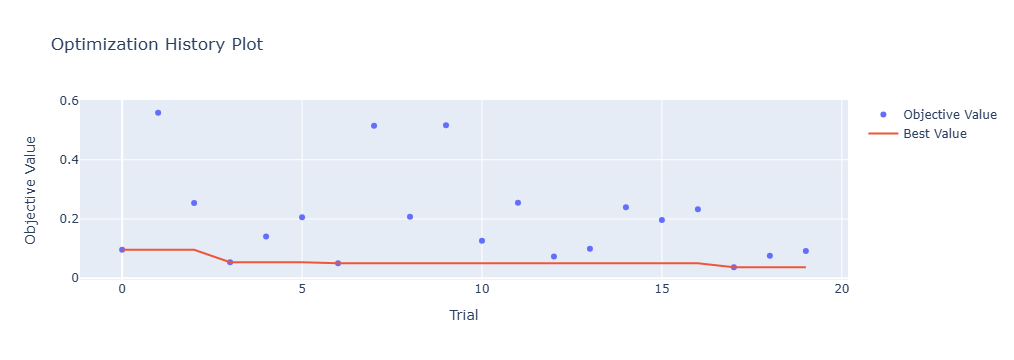

In [17]:
# Afficher l'historique de l'optimisation
fig = optuna.visualization.plot_optimization_history(study)
fig.show()


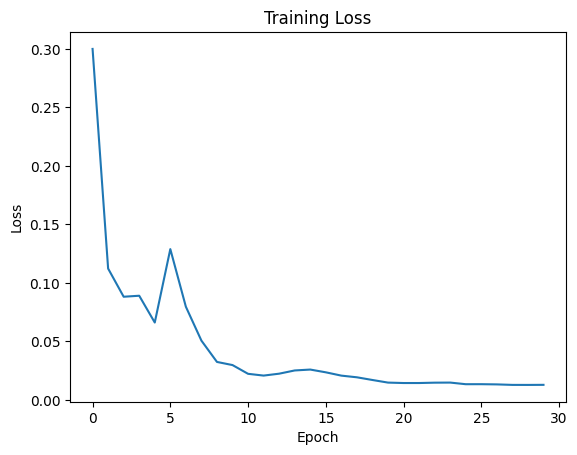

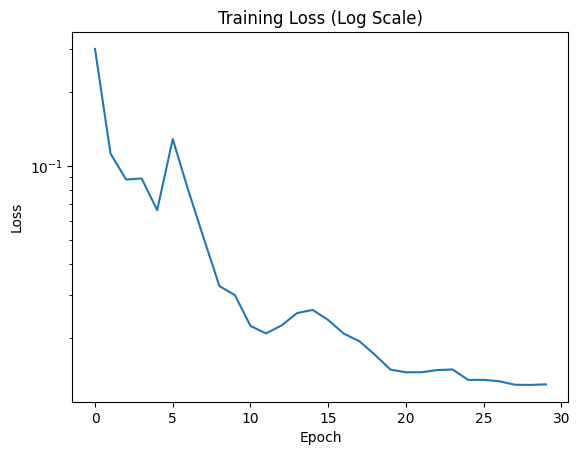

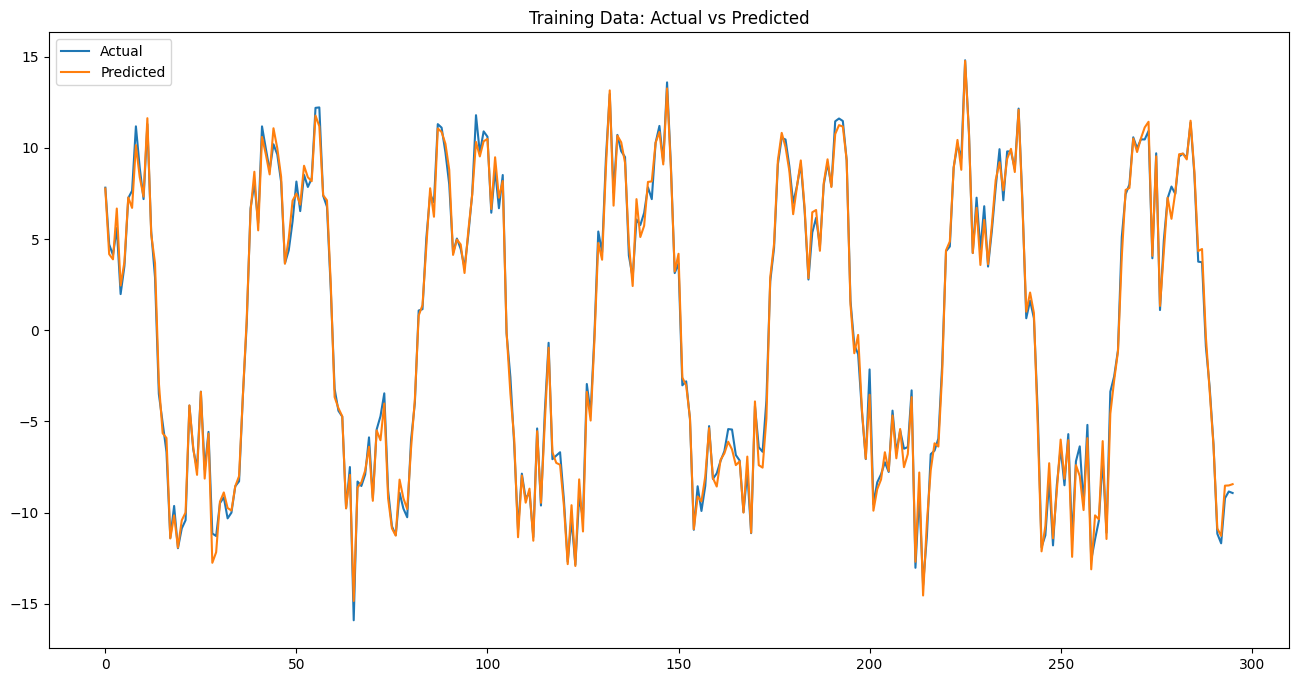

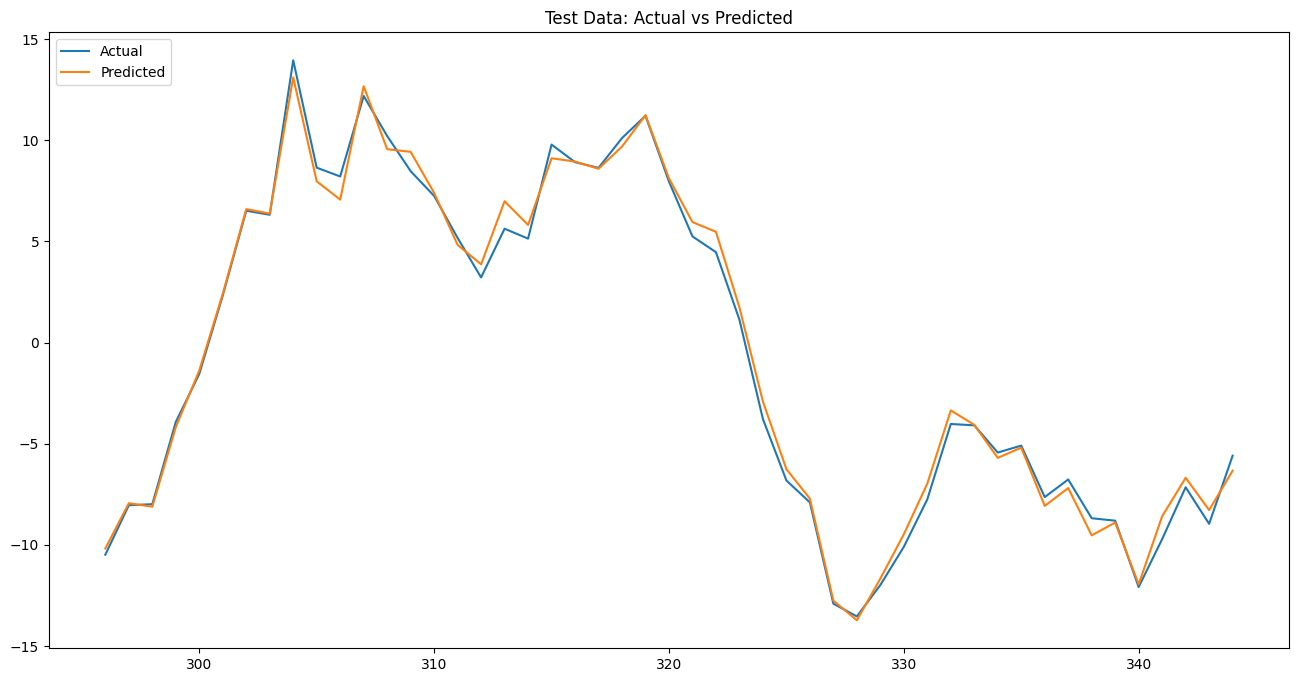

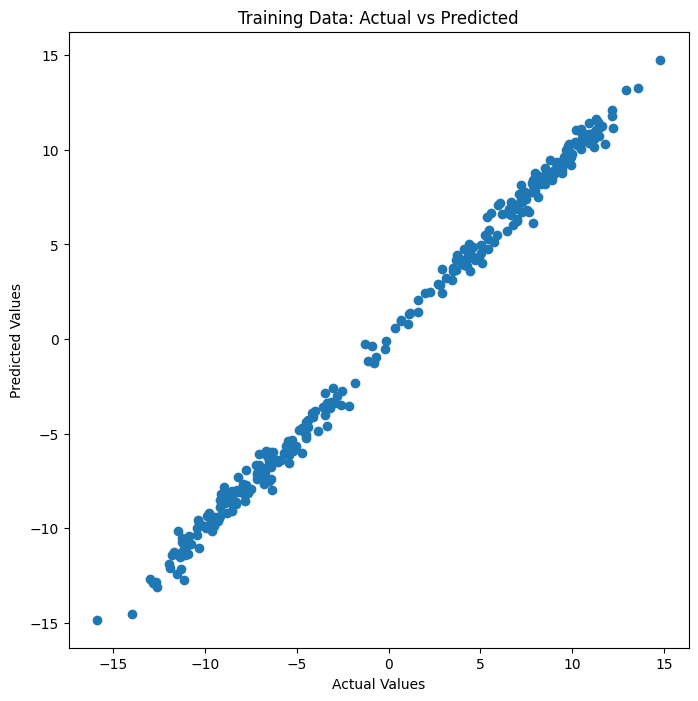

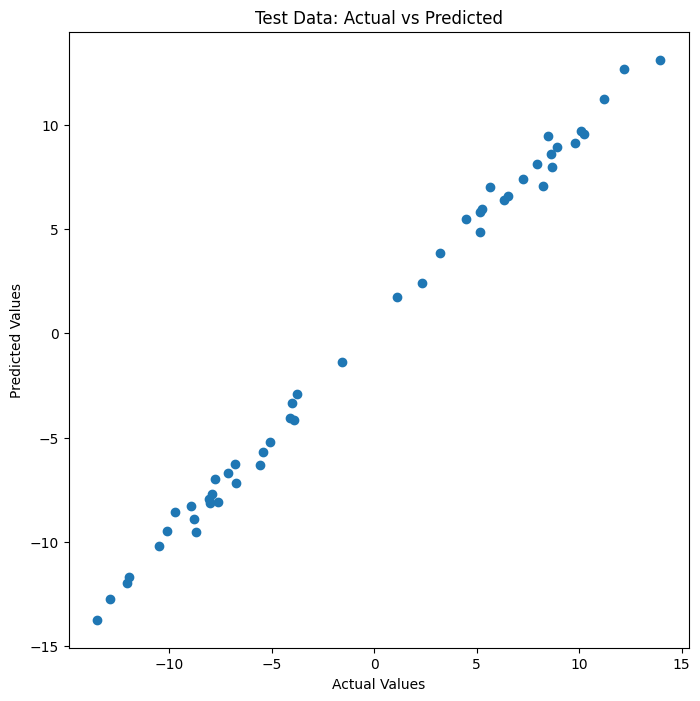

In [18]:
########## ENTRAINEMENT DU MODELE AVEC LES MEILLEURS HYPERPARAMETRE OPTUNA  ##########
########## UTILISATION DE L'ENSEMBLE DES DONNEES D'ENTRAINEMENT (PAS DE VALIDATION SPLIT) ##########

# Fixer la graine pour la reproductibilité
set_seed(seed)

# Récupérer les meilleurs hyperparamètres de l'étude Optuna
best_params = study.best_trial.params

# Reconstruction des listes de tailles de couches cachées pour CNN et LSTM
hidden_sizes_cnn = [best_params[f'hidden_size_cnn_{i}'] for i in range(best_params.get('num_cnn_layers', 0))]
hidden_sizes_lstm = [best_params[f'hidden_size_lstm_{i}'] for i in range(best_params.get('num_lstm_layers', 0))]

activation_functions_cnn = [best_params[f'activation_function_cnn_{i}'] for i in range(best_params.get('num_cnn_layers', 0))]
activation_functions_lstm = [best_params[f'activation_function_lstm_{i}'] for i in range(best_params.get('num_lstm_layers', 0))]

optimizer_name = best_params['optimizer']
max_norm = best_params['max_norm']

# Paramètres additionnels
stride = best_params['stride']
padding = 'same' 
lr = best_params['learning_rate']
weight_decay = best_params['weight_decay']
lr_decay_rate = best_params['lr_decay_rate']

# Récupérer lr_decay_step si nécessaire
lr_scheduler_type = best_params['lr_scheduler']
if lr_scheduler_type == 'StepLR':
    lr_decay_step = best_params['lr_decay_step']
else:
    lr_decay_step = None


input_size = training_set.shape[1]

# **Instancier le modèle avec les meilleurs hyperparamètres**
best_model = CNNBiLSTM(
    input_size=input_size,
    num_cnn_layers=best_params.get('num_cnn_layers', 0),
    num_lstm_layers=best_params.get('num_lstm_layers', 0),
    kernel_size=best_params['kernel_size'],
    hidden_sizes_cnn=hidden_sizes_cnn,
    hidden_sizes_lstm=hidden_sizes_lstm,
    bidirectional=best_params['bidirectional'],
    output_size=1,  # Ajustez selon votre cas d'utilisation
    activation_functions_cnn=activation_functions_cnn,
    activation_functions_lstm=activation_functions_lstm,
    dropout_rate=best_params['dropout_rate'],
    stride=stride,
    padding=padding
).to(device)

# Créer les fenêtres glissantes pour l'entraînement et le test
seq_length = best_params['seq_length']
x_train, y_train = sliding_windows(training_set, target_set, seq_length)
x_test, y_test = sliding_windows(X_test_scaled, Y_test_scaled, seq_length)

# Convertir en tenseurs
trainX = torch.Tensor(x_train).to(device)
trainY = torch.Tensor(y_train).to(device)

testX = torch.Tensor(x_test).to(device)
testY = torch.Tensor(y_test).to(device)

# Création du DataLoader pour l'entraînement
batch_size = best_params['batch_size']
train_data = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

# Définition de la fonction de perte et de l'optimiseur
criterion = torch.nn.L1Loss()
optimizer = {
    'Adam': torch.optim.Adam(best_model.parameters(), lr=lr, weight_decay=weight_decay),
    'RMSprop': torch.optim.RMSprop(best_model.parameters(), lr=lr, weight_decay=weight_decay),
    'SGD': torch.optim.SGD(best_model.parameters(), lr=lr, weight_decay=weight_decay)
}[optimizer_name]

# Ajouter le scheduler si nécessaire
if lr_scheduler_type == 'StepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
elif lr_scheduler_type == 'ExponentialLR':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_rate)
elif lr_scheduler_type == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_decay_rate, patience=10)
else:
    scheduler = None

# Boucle d'entraînement sans validation
epoch_losses = []
best_loss = float('inf')
best_model_state = None

for epoch in range(30):  # Vous pouvez ajuster le nombre d'époques
    total_loss = 0.0
    best_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        clip_grad_norm_(best_model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    
    # Mise à jour du scheduler si nécessaire
    if scheduler:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()
    
    # Sauvegarder le meilleur modèle basé sur la perte d'entraînement
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_state = best_model.state_dict()
        torch.save(best_model_state, 'best_model_checkpointepochs.pth')

# Charger le meilleur modèle après l'entraînement
best_model.load_state_dict(torch.load('best_model_checkpointepochs.pth'))

# Tracer la courbe de perte d'entraînement
plt.plot(epoch_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.semilogy(epoch_losses)
plt.title('Training Loss (Log Scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# **Évaluation du modèle**
best_model.eval()
with torch.no_grad():
    # Prédictions sur l'ensemble d'entraînement
    train_predict = best_model(trainX)
    # Prédictions sur l'ensemble de test
    test_predict = best_model(testX)

# Convertir les prédictions en valeurs originales
train_predict = scaler_Y.inverse_transform(train_predict.cpu().numpy())
trainY_true = scaler_Y.inverse_transform(trainY.cpu().numpy())

test_predict = scaler_Y.inverse_transform(test_predict.cpu().numpy())
testY_true = scaler_Y.inverse_transform(testY.cpu().numpy())

# Tracé des résultats
train_size = len(trainY_true)
test_size = len(testY_true)
train_time = np.arange(train_size)
test_time = np.arange(train_size, train_size + test_size)

# Données d'entraînement, réel vs prédit
plt.figure(figsize=(16,8))
plt.plot(train_time, trainY_true, label='Actual')
plt.plot(train_time, train_predict, label='Predicted')
plt.legend(loc='upper left')
plt.title('Training Data: Actual vs Predicted')
plt.show()

# Données de test, réel vs prédit
plt.figure(figsize=(16,8))
plt.plot(test_time, testY_true, label='Actual')
plt.plot(test_time, test_predict, label='Predicted')
plt.legend(loc='upper left')
plt.title('Test Data: Actual vs Predicted')
plt.show()

# Scatter plot pour les données d'entraînement
plt.figure(figsize=(8,8))
plt.scatter(trainY_true, train_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Data: Actual vs Predicted')
plt.show()

# Scatter plot pour les données de test
plt.figure(figsize=(8,8))
plt.scatter(testY_true, test_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data: Actual vs Predicted')
plt.show()


In [19]:
# Calcul des métriques pour l'ensemble d'entraînement
mse_train = mean_squared_error(trainY_true, train_predict)
mae_train = mean_absolute_error(trainY_true, train_predict)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(trainY_true, train_predict)

# Le coefficient d'efficacité de Nash-Sutcliffe pour l'ensemble d'entraînement
nse_train = 1 - sum((train_predict.flatten() - trainY_true.flatten())**2) / sum((trainY_true.flatten() - np.mean(trainY_true.flatten()))**2)

# Calcul des métriques pour l'ensemble de test
mse_test = mean_squared_error(testY_true, test_predict)
mae_test = mean_absolute_error(testY_true, test_predict)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(testY_true, test_predict)

# Le coefficient d'efficacité de Nash-Sutcliffe pour l'ensemble de test
nse_test = 1 - sum((test_predict.flatten() - testY_true.flatten())**2) / sum((testY_true.flatten() - np.mean(testY_true.flatten()))**2)

# Affichage des résultats
print("Training Metrics:")
print(f"MSE: {mse_train}, MAE: {mae_train}, RMSE: {rmse_train}, R^2: {r2_train}, NSE: {nse_train}")

print("\nTest Metrics:")
print(f"MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, R^2: {r2_test}, NSE: {nse_test}")

Training Metrics:
MSE: 0.27712759375572205, MAE: 0.4071231782436371, RMSE: 0.5264291167259216, R^2: 0.9956800262117639, NSE: 0.9956800262117639

Test Metrics:
MSE: 0.3281319737434387, MAE: 0.4580135643482208, RMSE: 0.5728280544281006, R^2: 0.9950578434799289, NSE: 0.9950578434799289


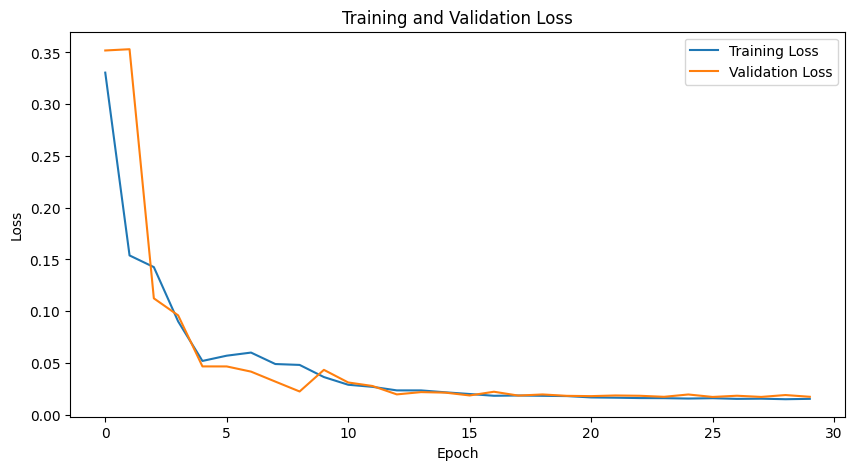

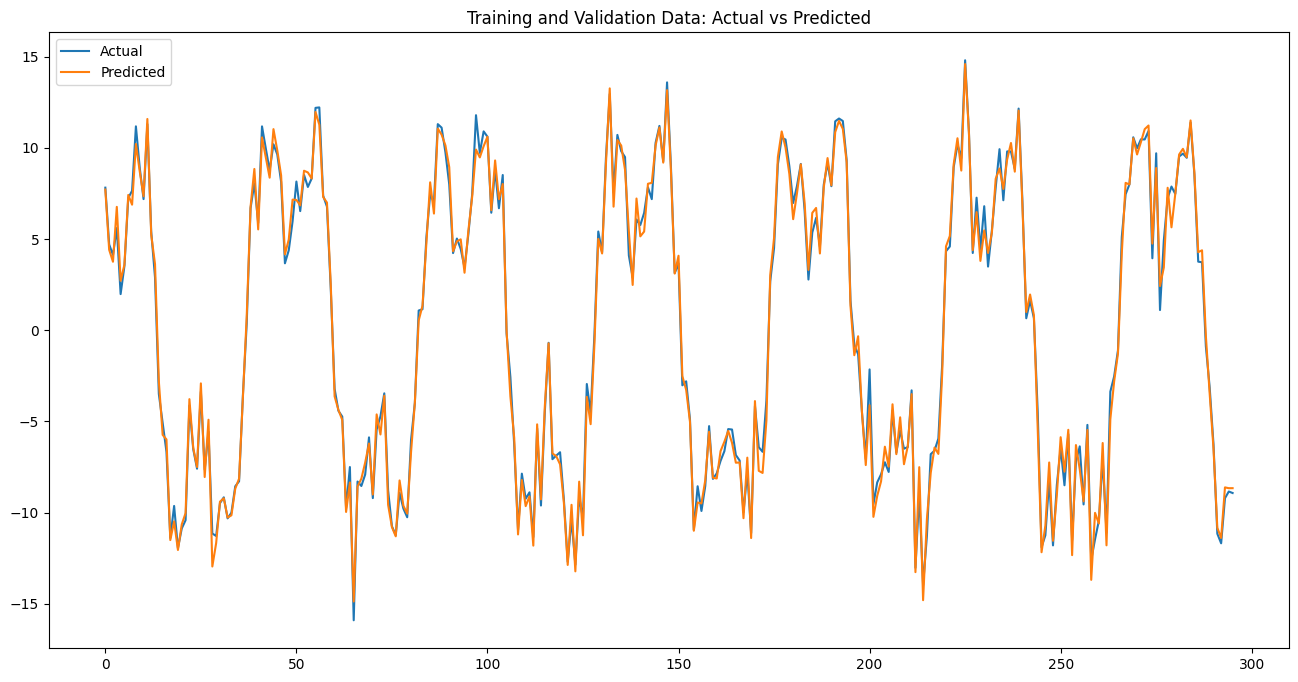

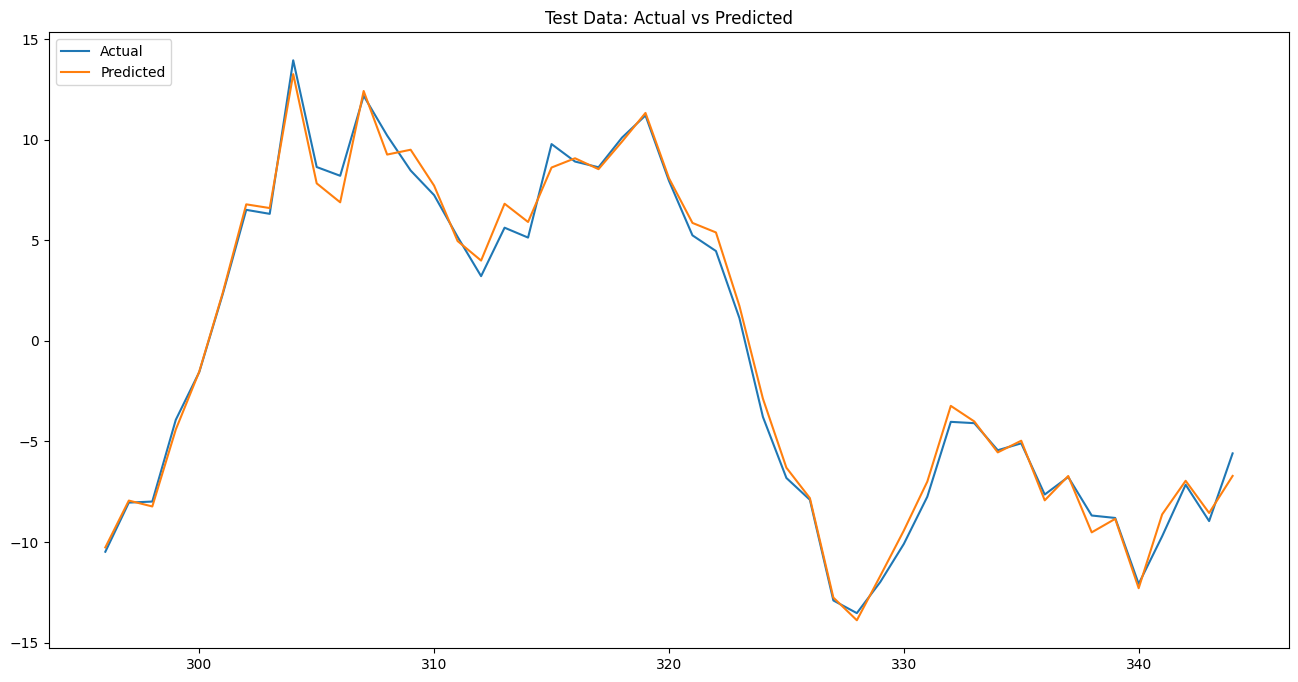

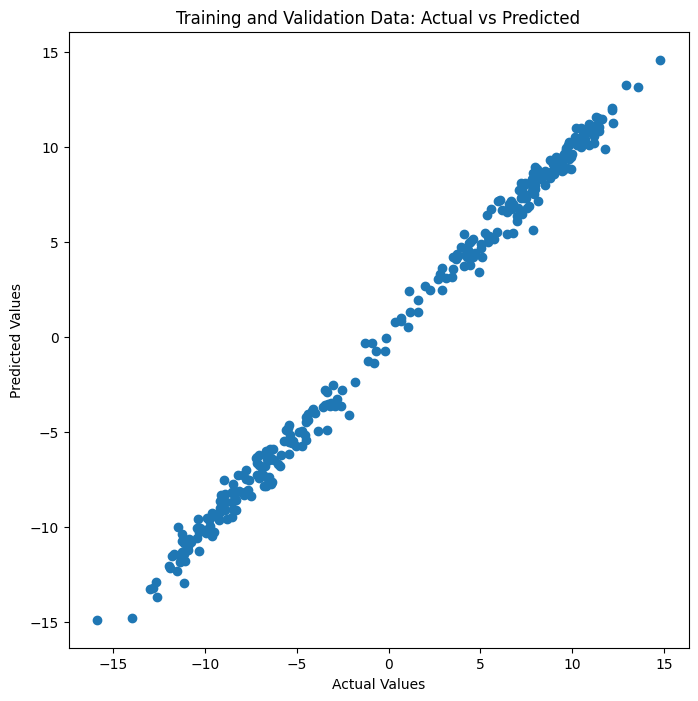

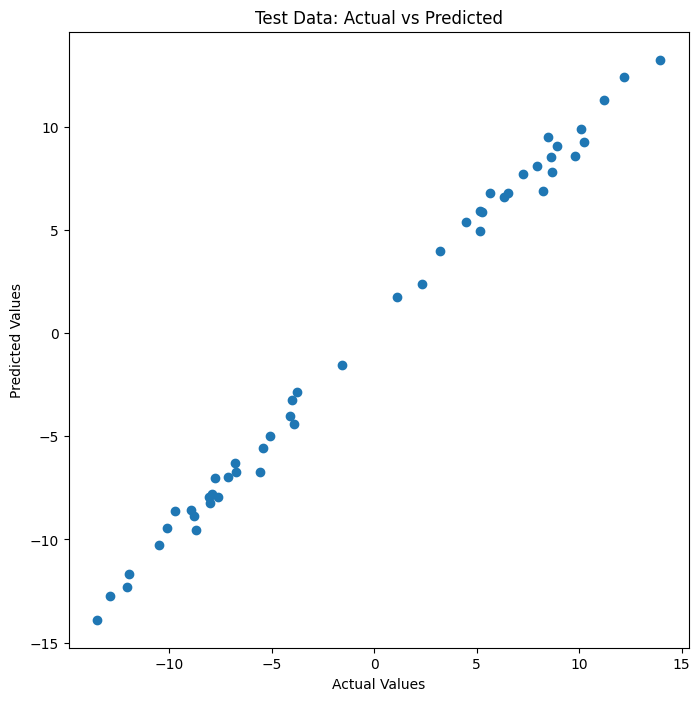

In [20]:
########## ENTRAINEMENT DU MODELE AVEC LES MEILLEURS HYPERPARAMETRE OPTUNA  ##########
########## UTILISATION DE L'ENSEMBLE DES DONNEES D'ENTRAINEMENT (PAS DE VALIDATION SPLIT) ##########


# Fixer la graine pour la reproductibilité
set_seed(seed)

# Récupérer les meilleurs hyperparamètres de l'étude Optuna

# Extraction des hyperparamètres
hidden_sizes_cnn = [best_params[f'hidden_size_cnn_{i}'] for i in range(best_params.get('num_cnn_layers', 0))]
hidden_sizes_lstm = [best_params[f'hidden_size_lstm_{i}'] for i in range(best_params.get('num_lstm_layers', 0))]

activation_functions_cnn = [best_params[f'activation_function_cnn_{i}'] for i in range(best_params.get('num_cnn_layers', 0))]
activation_functions_lstm = [best_params[f'activation_function_lstm_{i}'] for i in range(best_params.get('num_lstm_layers', 0))]

optimizer_name = best_params['optimizer']
max_norm = best_params['max_norm']

# Paramètres additionnels
stride = best_params['stride']
padding = 'same'  # Assurez-vous que votre version de PyTorch supporte 'same' pour Conv1d
lr = best_params['learning_rate']
weight_decay = best_params['weight_decay']
lr_decay_rate = best_params['lr_decay_rate']

# Récupérer lr_decay_step si nécessaire
lr_scheduler_type = best_params['lr_scheduler']
if lr_scheduler_type == 'StepLR':
    lr_decay_step = best_params['lr_decay_step']
else:
    lr_decay_step = None

# Définir input_size
input_size = training_set.shape[1]

# Instancier le modèle avec les meilleurs hyperparamètres
best_model = CNNBiLSTM(
    input_size=input_size,
    num_cnn_layers=best_params.get('num_cnn_layers', 0),
    num_lstm_layers=best_params.get('num_lstm_layers', 0),
    kernel_size=best_params['kernel_size'],
    hidden_sizes_cnn=hidden_sizes_cnn,
    hidden_sizes_lstm=hidden_sizes_lstm,
    bidirectional=best_params['bidirectional'],
    output_size=1,  # Ajustez selon votre cas d'utilisation
    activation_functions_cnn=activation_functions_cnn,
    activation_functions_lstm=activation_functions_lstm,
    dropout_rate=best_params['dropout_rate'],
    stride=stride,
    padding=padding
).to(device)

# Préparer les données
# Créer les fenêtres glissantes pour l'entraînement et le test
seq_length = best_params['seq_length']
x_train_full, y_train_full = sliding_windows(training_set, target_set, seq_length)
x_test, y_test = sliding_windows(X_test_scaled, Y_test_scaled, seq_length)

# Convertir en tenseurs
x_train_full = torch.Tensor(x_train_full).to(device)
y_train_full = torch.Tensor(y_train_full).to(device)

testX = torch.Tensor(x_test).to(device)
testY = torch.Tensor(y_test).to(device)

# Séparer 20% des données d'entraînement pour la validation
val_size = int(0.2 * len(x_train_full))
train_size = len(x_train_full) - val_size

trainX = x_train_full[:train_size]
trainY = y_train_full[:train_size]

valX = x_train_full[train_size:]
valY = y_train_full[train_size:]

# Création des DataLoaders pour l'entraînement et la validation
batch_size = best_params['batch_size']
train_data = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

val_data = TensorDataset(valX, valY)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Définition de la fonction de perte et de l'optimiseur
criterion = torch.nn.L1Loss()
optimizer = {
    'Adam': torch.optim.Adam(best_model.parameters(), lr=lr, weight_decay=weight_decay),
    'RMSprop': torch.optim.RMSprop(best_model.parameters(), lr=lr, weight_decay=weight_decay),
    'SGD': torch.optim.SGD(best_model.parameters(), lr=lr, weight_decay=weight_decay)
}[optimizer_name]

# Ajouter le scheduler si nécessaire
if lr_scheduler_type == 'StepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
elif lr_scheduler_type == 'ExponentialLR':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_rate)
elif lr_scheduler_type == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_decay_rate, patience=10)
else:
    scheduler = None

# Boucle d'entraînement avec validation
epoch_losses = []
epoch_val_losses = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(30):  # Vous pouvez ajuster le nombre d'époques
    total_loss = 0.0
    best_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        clip_grad_norm_(best_model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    
    # Validation
    best_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = best_model(inputs)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()
    epoch_val_loss = total_val_loss / len(val_loader)
    epoch_val_losses.append(epoch_val_loss)
    
    # Mise à jour du scheduler si nécessaire
    if scheduler:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)
        else:
            scheduler.step()
    
    # Sauvegarder le meilleur modèle basé sur la perte de validation
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = best_model.state_dict()
        torch.save(best_model_state, 'best_model_checkpoint_with_validation20%.pth')

# Charger le meilleur modèle après l'entraînement
best_model.load_state_dict(torch.load('best_model_checkpoint_with_validation20%.pth'))

# Tracer les courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Évaluation du modèle
best_model.eval()
with torch.no_grad():
    # Prédictions sur l'ensemble d'entraînement complet (train + val)
    train_val_X = torch.cat((trainX, valX), dim=0)
    train_val_Y = torch.cat((trainY, valY), dim=0)
    train_val_predict = best_model(train_val_X)
    
    # Prédictions sur l'ensemble de test
    test_predict = best_model(testX)

# Convertir les prédictions en valeurs originales
train_val_predict = scaler_Y.inverse_transform(train_val_predict.cpu().numpy())
train_val_Y_true = scaler_Y.inverse_transform(train_val_Y.cpu().numpy())

test_predict = scaler_Y.inverse_transform(test_predict.cpu().numpy())
testY_true = scaler_Y.inverse_transform(testY.cpu().numpy())

# Tracé des résultats
train_val_size = len(train_val_Y_true)
test_size = len(testY_true)
train_val_time = np.arange(train_val_size)
test_time = np.arange(train_val_size, train_val_size + test_size)

# Données d'entraînement (train + val), réel vs prédit
plt.figure(figsize=(16,8))
plt.plot(train_val_time, train_val_Y_true, label='Actual')
plt.plot(train_val_time, train_val_predict, label='Predicted')
plt.legend(loc='upper left')
plt.title('Training and Validation Data: Actual vs Predicted')
plt.show()

# Données de test, réel vs prédit
plt.figure(figsize=(16,8))
plt.plot(test_time, testY_true, label='Actual')
plt.plot(test_time, test_predict, label='Predicted')
plt.legend(loc='upper left')
plt.title('Test Data: Actual vs Predicted')
plt.show()

# Scatter plot pour les données d'entraînement (train + val)
plt.figure(figsize=(8,8))
plt.scatter(train_val_Y_true, train_val_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training and Validation Data: Actual vs Predicted')
plt.show()

# Scatter plot pour les données de test
plt.figure(figsize=(8,8))
plt.scatter(testY_true, test_predict)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data: Actual vs Predicted')
plt.show()


In [21]:

# Calcul des métriques pour l'ensemble d'entraînement
mse_train = mean_squared_error(trainY_true, train_predict)
mae_train = mean_absolute_error(trainY_true, train_predict)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(trainY_true, train_predict)

# Le coefficient d'efficacité de Nash-Sutcliffe pour l'ensemble d'entraînement
nse_train = 1 - sum((train_predict.flatten() - trainY_true.flatten())**2) / sum((trainY_true.flatten() - np.mean(trainY_true.flatten()))**2)

# Calcul des métriques pour l'ensemble de test
mse_test = mean_squared_error(testY_true, test_predict)
mae_test = mean_absolute_error(testY_true, test_predict)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(testY_true, test_predict)

# Le coefficient d'efficacité de Nash-Sutcliffe pour l'ensemble de test
nse_test = 1 - sum((test_predict.flatten() - testY_true.flatten())**2) / sum((testY_true.flatten() - np.mean(testY_true.flatten()))**2)

# Affichage des résultats
print("Training Metrics:")
print(f"MSE: {mse_train}, MAE: {mae_train}, RMSE: {rmse_train}, R^2: {r2_train}, NSE: {nse_train}")

print("\nTest Metrics:")
print(f"MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, R^2: {r2_test}, NSE: {nse_test}")

Training Metrics:
MSE: 0.27712759375572205, MAE: 0.4071231782436371, RMSE: 0.5264291167259216, R^2: 0.9956800262117639, NSE: 0.9956800262117639

Test Metrics:
MSE: 0.36417749524116516, MAE: 0.47468310594558716, RMSE: 0.6034712195396423, R^2: 0.9945149439304688, NSE: 0.9945149439304688


In [22]:
# random seeds
torch.manual_seed(0)
np.random.seed(0)

# Disable cuDNN if necessary
torch.backends.cudnn.enabled = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [23]:
# Utilisation du meilleur modèle après optimisation
best_model.eval()
best_model.to(device)

CNNBiLSTM(
  (cnns): ModuleList(
    (0): Conv1d(3, 790, kernel_size=(10,), stride=(2,), padding=(5,))
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(790, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (activations_cnn): ModuleList(
    (0): Tanh()
  )
  (lstm_layers): ModuleList()
  (activations): ModuleList()
  (dropouts): ModuleList()
  (fc): Linear(in_features=790, out_features=1, bias=True)
)

In [24]:
trainX = trainX.to(device)
testX = testX.to(device)
background = trainX  
test_samples = testX  


test_samples.requires_grad = True

In [25]:
def model_forward(x):
    output = best_model(x)
    if output.dim() == 1:
        output = output.unsqueeze(1)
    return output

In [26]:
# Initialisation GradientShap
gs = GradientShap(model_forward)


n_samples = 200  # Nombres d'échantillons

# Calculattributions
attributions_captum = gs.attribute(
    test_samples,
    baselines=background,
    target=None,
    n_samples=n_samples,
    stdevs=0.0  
)


In [27]:
# nitialisation explainer
explainer = shap.GradientExplainer(best_model, background)


shap_values = explainer.shap_values(test_samples, nsamples=n_samples)

In [28]:
# Captum
attributions_captum_np = attributions_captum.detach().cpu().numpy()
attributions_captum_aggregated = np.mean(attributions_captum_np, axis=1)  # Shape: [num_samples, num_features]

# SHAP
shap_values_np = np.array(shap_values)
if shap_values_np.ndim == 4:
    
    shap_values_np = shap_values_np[0]  
shap_values_aggregated = np.mean(shap_values_np, axis=1)  # Shape: [num_samples, num_features]


In [29]:
print("Captum attributions shape:", attributions_captum_aggregated.shape)
print("SHAP attributions shape:", shap_values_aggregated.shape)

Captum attributions shape: (49, 3)
SHAP attributions shape: (49, 3)


In [30]:
# Captum
mean_abs_attributions_captum = np.mean(np.abs(attributions_captum_aggregated), axis=0)

# SHAP
mean_abs_attributions_shap = np.mean(np.abs(shap_values_aggregated), axis=0)

In [31]:
# Normalisation
mean_abs_attributions_captum /= np.sum(mean_abs_attributions_captum)
mean_abs_attributions_shap /= np.sum(mean_abs_attributions_shap)

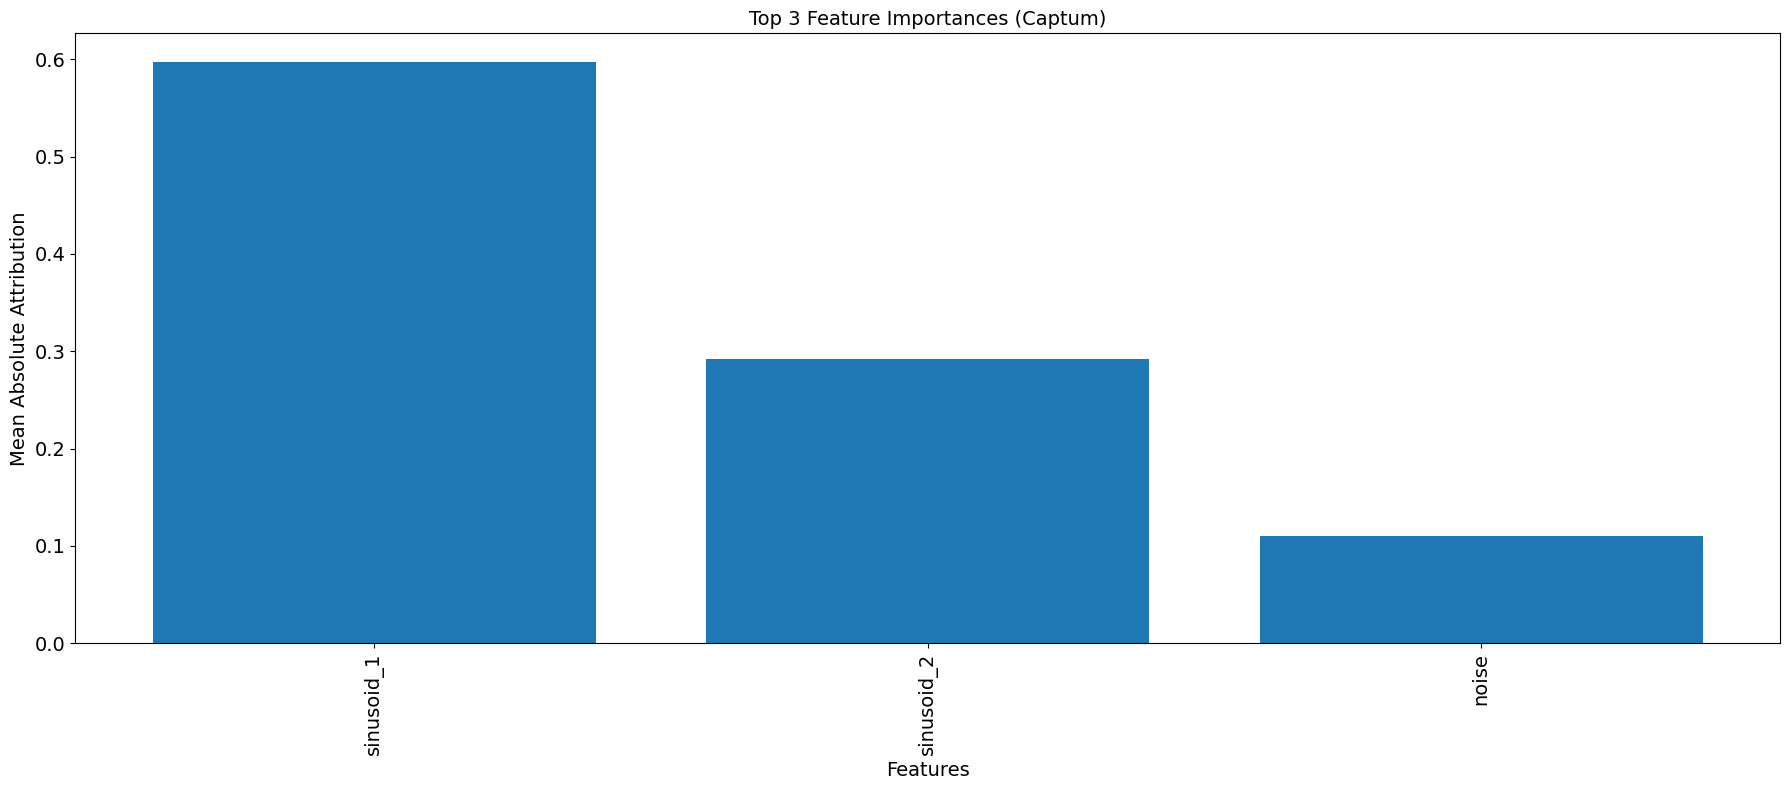

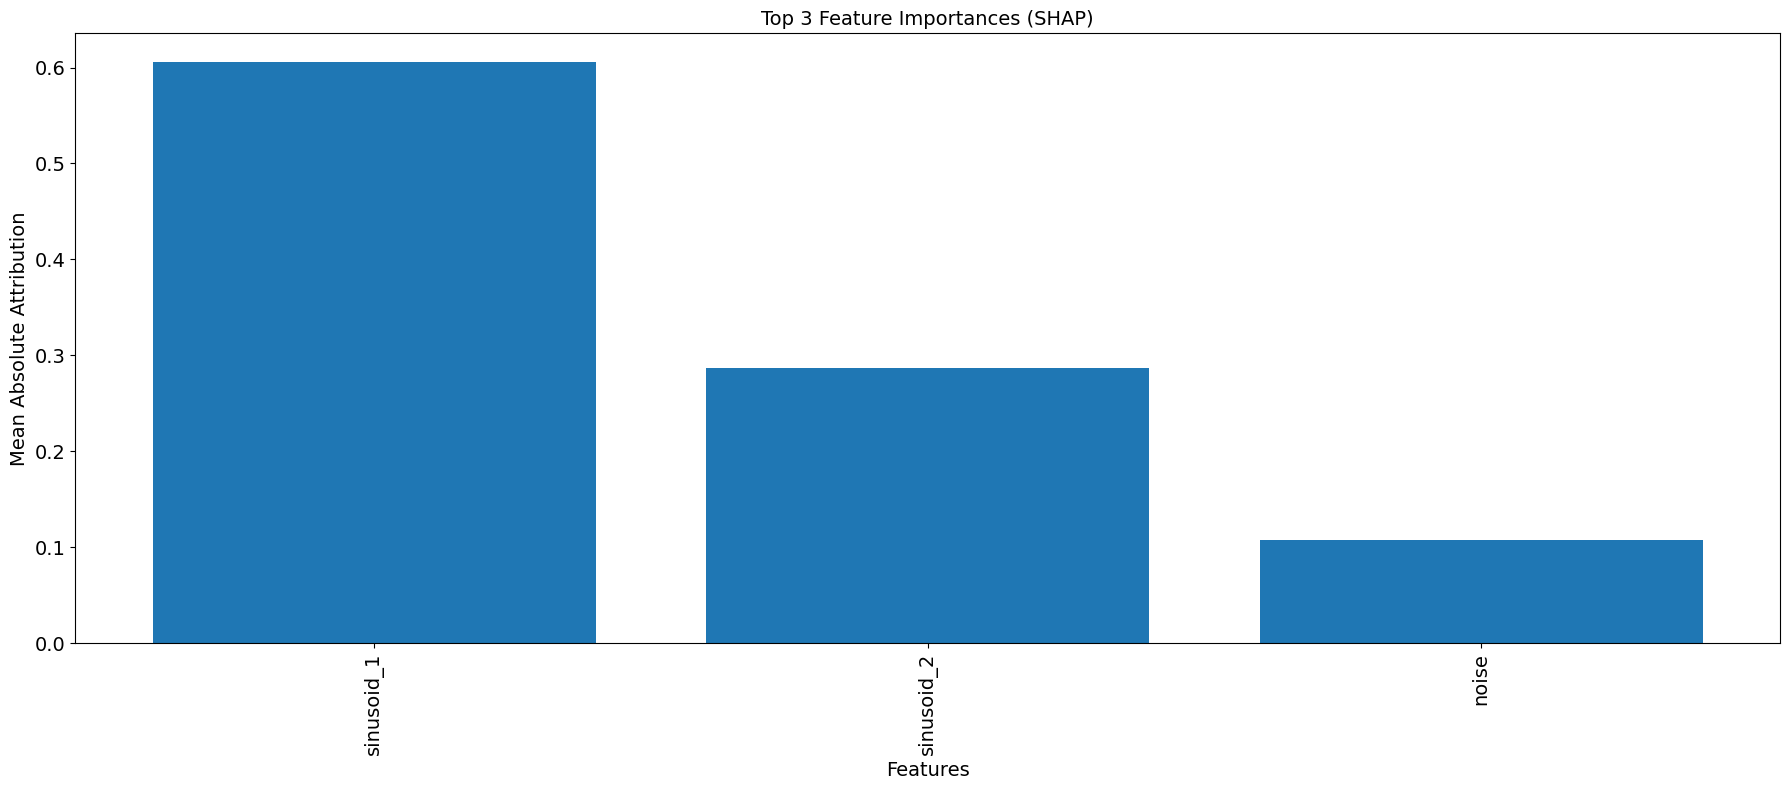

In [32]:

feature_names = dataset.drop(['Target'], axis=1).columns.tolist()

# Nombre de features à afficher
N = 3

# Get indices of top N features based on Captum attributions
indices_captum = np.argsort(mean_abs_attributions_captum)[::-1][:N]

# Get indices of top N features based on SHAP attributions
indices_shap = np.argsort(mean_abs_attributions_shap)[::-1][:N]

# Plot Captum 
plt.figure(figsize=(18, 8))
plt.bar(range(N), mean_abs_attributions_captum[indices_captum])
plt.xticks(range(N), [feature_names[i] for i in indices_captum], rotation='vertical')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Mean Absolute Attribution', fontsize=14)
plt.title(f'Top {N} Feature Importances (Captum)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Plot SHAP 
plt.figure(figsize=(18, 8))
plt.bar(range(N), mean_abs_attributions_shap[indices_shap])
plt.xticks(range(N), [feature_names[i] for i in indices_shap], rotation='vertical')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Mean Absolute Attribution', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Top {N} Feature Importances (SHAP)', fontsize=14)
plt.tight_layout()
plt.show()


In [33]:
sorted_indices = np.argsort(feature_names)

captum_attrs_sorted = mean_abs_attributions_captum[sorted_indices]
shap_attrs_sorted = mean_abs_attributions_shap[sorted_indices]

# Calcul coefficient de Pearson
correlation, _ = pearsonr(captum_attrs_sorted, shap_attrs_sorted)
print(f"Correlation between Captum and SHAP attributions: {correlation}")


Correlation between Captum and SHAP attributions: 0.9998528892480028


Shape of shap_values: (49, 10, 3)
Shape of test_samples: torch.Size([49, 10, 3])
Shape of shap_values_aggregated: (49, 3)
Number of features in testX_array: 3
Number of features in feature_names: 3


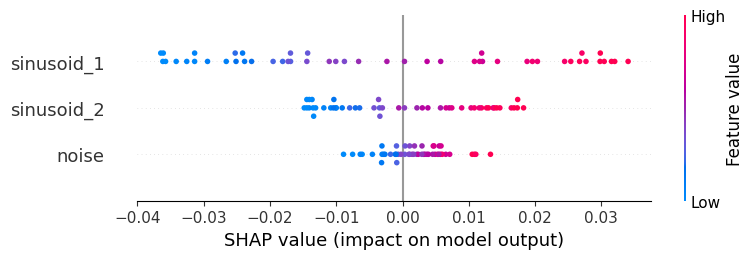

In [34]:
# Désactiver cuDNN pour éviter les problèmes avec LSTM
torch.backends.cudnn.enabled = False

# Utiliser un sous-ensemble des données pour l'explication
background = trainX[:50]  # Utiliser les 100 premiers échantillons comme fond
test_samples = testX[:50]  # Utiliser les 10 premiers échantillons pour l'explication

# Initialiser l'explainer
explainer = shap.GradientExplainer(best_model, background)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(test_samples)

# Vérifier les dimensions des valeurs SHAP
print("Shape of shap_values:", np.array(shap_values).shape)
print("Shape of test_samples:", test_samples.shape)

# Agréger les valeurs SHAP sur la dimension temporelle
shap_values_aggregated = np.mean(shap_values, axis=1)

# Vérifier les nouvelles dimensions des valeurs SHAP
print("Shape of shap_values_aggregated:", shap_values_aggregated.shape)

# Conversion des résultats de SHAP en numpy arrays pour visualisation
testX_array = test_samples.cpu().detach().numpy()

# Assurez-vous que le nombre de features correspond
feature_names = dataset.drop(['Target'], axis=1).columns

# Vérifier les dimensions des features
print("Number of features in testX_array:", testX_array.shape[2])  # Vérifier la troisième dimension pour les séquences
print("Number of features in feature_names:", len(feature_names))

# Visualisation des valeurs de SHAP
shap.summary_plot(shap_values_aggregated, testX_array[:, -1, :], feature_names=feature_names, max_display=20)


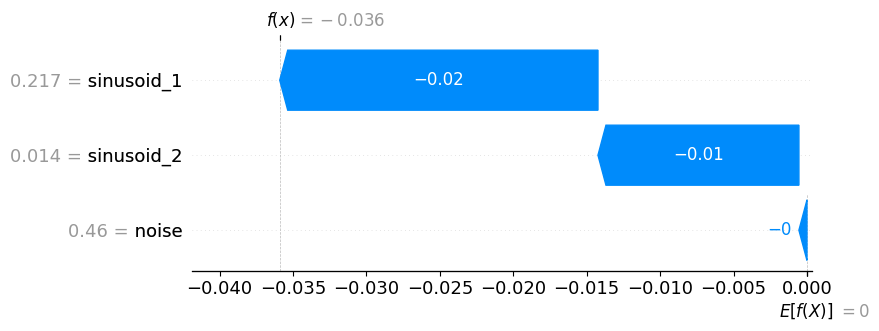

In [35]:
# Désactiver cuDNN pour éviter les problèmes avec LSTM
torch.backends.cudnn.enabled = False

# Exemple pour choisir les indices
n_background = 100  # Taille du fond
n_test_samples = 10  # Taille des échantillons de test


background = trainX # Utiliser les n_background premiers échantillons comme fond
test_samples = testX  # Utiliser les n_test_samples premiers échantillons pour l'explication

# Initialiser l'explainer
explainer = shap.GradientExplainer(best_model, background)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(test_samples)

# Agréger les valeurs SHAP sur la dimension temporelle
shap_values_aggregated = np.mean(shap_values, axis=1)

# Conversion des résultats de SHAP en numpy arrays pour visualisation
testX_array = test_samples.cpu().detach().numpy()

# Assurez-vous que le nombre de features correspond
feature_names = dataset.drop(['Target'], axis=1).columns

# Créer un objet shap.Explanation
expl = shap.Explanation(values=shap_values_aggregated, base_values=np.zeros(shap_values_aggregated.shape[0]), data=testX_array[:, -1, :], feature_names=feature_names)

# Visualisation des valeurs de SHAP avec wterfall plot
shap.waterfall_plot(expl[0], max_display=10)
